# Dataset Foundation & Structure Analysis
## Open Food Facts Dataset for NutriFoodBot Project

This notebook performs comprehensive foundational analysis of the Open Food Facts dataset, focusing on:
- Data loading strategies and memory optimization
- Schema analysis and column structure mapping
- Data type optimization and storage efficiency
- Missing data patterns and completeness evaluation
- Data quality flags and reliability indicators
- Sample vs full dataset comparison strategies

**Analysis #1 from NutriFoodBot EDA Roadmap**

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datasets import load_dataset
import sys
import psutil
import gc
from typing import Dict, List, Tuple, Any

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Python version: 3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]
Pandas version: 2.3.1
NumPy version: 2.3.1


## 1. Data Loading Strategies & Memory Optimization

In [2]:
def get_memory_usage() -> Dict[str, float]:
    """Get current memory usage statistics"""
    process = psutil.Process()
    memory_info = process.memory_info()
    return {
        'rss_mb': memory_info.rss / 1024 / 1024,  # Resident Set Size
        'vms_mb': memory_info.vms / 1024 / 1024,  # Virtual Memory Size
        'percent': process.memory_percent()
    }

def load_dataset_sample(sample_size: str = "1%") -> Tuple[Any, Dict[str, float]]:
    """Load dataset sample with memory tracking"""
    print(f"Loading {sample_size} sample of the dataset...")
    memory_before = get_memory_usage()
    
    # Load dataset sample
    dataset = load_dataset("parquet", data_files="food.parquet", split=f"train[:{sample_size}]")
    
    memory_after = get_memory_usage()
    memory_used = {
        'before_mb': memory_before['rss_mb'],
        'after_mb': memory_after['rss_mb'],
        'used_mb': memory_after['rss_mb'] - memory_before['rss_mb']
    }
    
    print(f"Dataset shape: {dataset.shape}")
    print(f"Memory used: {memory_used['used_mb']:.2f} MB")
    
    return dataset, memory_used

# Load initial sample
dataset_1pct, memory_stats_1pct = load_dataset_sample("1%")

Loading 1% sample of the dataset...
Dataset shape: (39191, 110)
Memory used: 19.69 MB


In [3]:
# Convert to pandas DataFrame and analyze memory usage
print("Converting to pandas DataFrame...")
memory_before_df = get_memory_usage()

df = dataset_1pct.to_pandas()

memory_after_df = get_memory_usage()
memory_df_conversion = memory_after_df['rss_mb'] - memory_before_df['rss_mb']

print(f"DataFrame shape: {df.shape}")
print(f"Memory used for DataFrame conversion: {memory_df_conversion:.2f} MB")
print(f"DataFrame memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Basic DataFrame info
print(f"\nDataFrame Info:")
print(f"- Rows: {df.shape[0]:,}")
print(f"- Columns: {df.shape[1]}")
print(f"- Total cells: {df.shape[0] * df.shape[1]:,}")

Converting to pandas DataFrame...
DataFrame shape: (39191, 110)
Memory used for DataFrame conversion: 1480.71 MB
DataFrame memory usage: 513.47 MB

DataFrame Info:
- Rows: 39,191
- Columns: 110
- Total cells: 4,311,010


## 2. Comprehensive Schema Analysis & Column Structure Mapping

In [4]:
def analyze_column_structure(df: pd.DataFrame) -> pd.DataFrame:
    """Comprehensive column structure analysis"""
    column_analysis = []
    
    for col in df.columns:
        col_data = df[col]
        
        # Basic info
        analysis = {
            'column_name': col,
            'data_type': str(col_data.dtype),
            'non_null_count': col_data.notna().sum(),
            'null_count': col_data.isna().sum(),
            'null_percentage': (col_data.isna().sum() / len(df)) * 100,
            'memory_usage_mb': col_data.memory_usage(deep=True) / 1024**2
        }
        
        # Safe unique count calculation
        try:
            analysis['unique_values'] = col_data.nunique()
        except (TypeError, ValueError):
            # Handle unhashable types (like numpy arrays)
            try:
                # Convert to string and count unique
                analysis['unique_values'] = col_data.astype(str).nunique()
            except:
                analysis['unique_values'] = -1  # Mark as unable to calculate
        
        # Sample values (non-null)
        non_null_values = col_data.dropna()
        if len(non_null_values) > 0:
            try:
                analysis['sample_values'] = list(non_null_values.head(3).astype(str))
            except:
                analysis['sample_values'] = ['<complex_data_structure>'] * min(3, len(non_null_values))
        else:
            analysis['sample_values'] = []
        
        # Data type specific analysis
        if col_data.dtype == 'object':
            # String analysis (only for simple string data)
            try:
                str_lengths = col_data.dropna().astype(str).str.len()
                analysis['avg_string_length'] = str_lengths.mean() if len(str_lengths) > 0 else 0
                analysis['max_string_length'] = str_lengths.max() if len(str_lengths) > 0 else 0
            except:
                analysis['avg_string_length'] = 0
                analysis['max_string_length'] = 0
                
        elif pd.api.types.is_numeric_dtype(col_data):
            # Numeric analysis
            try:
                analysis['min_value'] = col_data.min()
                analysis['max_value'] = col_data.max()
                analysis['mean_value'] = col_data.mean()
            except:
                analysis['min_value'] = None
                analysis['max_value'] = None
                analysis['mean_value'] = None
            
        column_analysis.append(analysis)
    
    return pd.DataFrame(column_analysis)

print("Analyzing column structure...")
column_analysis_df = analyze_column_structure(df)

print(f"\nColumn Analysis Summary:")
print(f"- Total columns: {len(column_analysis_df)}")
print(f"- Data types: {column_analysis_df['data_type'].value_counts().to_dict()}")
print(f"- Columns with >90% missing data: {(column_analysis_df['null_percentage'] > 90).sum()}")
print(f"- Columns with no missing data: {(column_analysis_df['null_percentage'] == 0).sum()}")
print(f"- Columns with complex data structures: {(column_analysis_df['unique_values'] == -1).sum()}")

Analyzing column structure...

Column Analysis Summary:
- Total columns: 110
- Data types: {'object': 83, 'float64': 19, 'int64': 4, 'int32': 2, 'float32': 1, 'bool': 1}
- Columns with >90% missing data: 11
- Columns with no missing data: 40
- Columns with complex data structures: 0


In [5]:
# Display all memory-consuming columns
print("\nAll Columns by Memory Consumption:")
all_memory_cols = column_analysis_df.sort_values('memory_usage_mb', ascending=False)[['column_name', 'data_type', 'memory_usage_mb', 'null_percentage']]
for idx, (_, row) in enumerate(all_memory_cols.iterrows(), 1):
    print(f"{idx:3d}. {row['column_name']:40s} | {row['data_type']:10s} | {row['memory_usage_mb']:8.2f} MB | {row['null_percentage']:6.1f}% null")

# Summary statistics
print(f"\nMemory Usage Summary:")
print(f"- Total memory: {all_memory_cols['memory_usage_mb'].sum():.2f} MB")
print(f"- Average memory per column: {all_memory_cols['memory_usage_mb'].mean():.2f} MB")
print(f"- Median memory per column: {all_memory_cols['memory_usage_mb'].median():.2f} MB")
print(f"- Top 10 columns account for: {all_memory_cols.head(10)['memory_usage_mb'].sum():.2f} MB ({(all_memory_cols.head(10)['memory_usage_mb'].sum()/all_memory_cols['memory_usage_mb'].sum())*100:.1f}%)")
print(f"- Columns using >1 MB: {(all_memory_cols['memory_usage_mb'] > 1).sum()}")
print(f"- Columns using <0.1 MB: {(all_memory_cols['memory_usage_mb'] < 0.1).sum()}")


All Columns by Memory Consumption:
  1. ingredients                              | object     |   222.88 MB |    4.1% null
  2. ecoscore_data                            | object     |    34.37 MB |   66.2% null
  3. categories_properties                    | object     |     7.18 MB |    0.0% null
  4. checkers_tags                            | object     |     4.49 MB |    0.0% null
  5. generic_name                             | object     |     4.49 MB |    0.0% null
  6. ingredients_text                         | object     |     4.49 MB |    0.0% null
  7. entry_dates_tags                         | object     |     4.49 MB |    0.0% null
  8. food_groups_tags                         | object     |     4.49 MB |    0.0% null
  9. data_quality_errors_tags                 | object     |     4.49 MB |    0.0% null
 10. data_quality_warnings_tags               | object     |     4.49 MB |    0.0% null
 11. countries_tags                           | object     |     4.49 MB |    0.0% n

In [6]:
# Categorize columns by domain/functionality
def categorize_columns(columns: List[str]) -> Dict[str, List[str]]:
    """Categorize columns by their functionality/domain"""
    categories = {
        'nutritional': [],
        'ingredients': [],
        'categories': [],
        'geographic': [],
        'packaging': [],
        'quality_scores': [],
        'metadata': [],
        'identifiers': [],
        'allergens': [],
        'brands': [],
        'labels_certifications': [],
        'data_quality': [],
        'other': []
    }
    
    for col in columns:
        col_lower = col.lower()
        
        # Nutritional data (including serving sizes, quantities, sweeteners, nucleotides)
        if any(term in col_lower for term in ['nutri', 'energy', 'protein', 'fat', 'carb', 'sugar', 'salt', 'sodium', 'fiber', 'vitamin', 'mineral', 'nucleotides']):
            categories['nutritional'].append(col)
        elif any(term in col_lower for term in ['serving', 'quantity', 'sweetener']):
            categories['nutritional'].append(col)
        
        # Ingredients and additives
        elif any(term in col_lower for term in ['ingredient', 'additives']):
            categories['ingredients'].append(col)
        
        # Categories and food groups
        elif any(term in col_lower for term in ['categor', 'food_group']):
            categories['categories'].append(col)
        
        # Geographic (including stores)
        elif any(term in col_lower for term in ['countr', 'origin', 'cities', 'manufacturing', 'purchase', 'stores']):
            categories['geographic'].append(col)
        
        # Packaging
        elif any(term in col_lower for term in ['packaging', 'packag']):
            categories['packaging'].append(col)
        
        # Quality scores
        elif any(term in col_lower for term in ['score', 'grade', 'nova', 'ecoscore']):
            categories['quality_scores'].append(col)
        
        # Data quality tags
        elif any(term in col_lower for term in ['data_quality', 'checkers_tags', 'correctors_tags', 'informers_tags']):
            categories['data_quality'].append(col)
        
        # Labels and certifications
        elif any(term in col_lower for term in ['labels']):
            categories['labels_certifications'].append(col)
        
        # Metadata (timestamps, editors, completeness, popularity, scans, language)
        elif any(term in col_lower for term in ['created', 'modified', 'updated', 'edit', 'rev', 'complete', 'last_image_t', 'popularity', 'scans_n', 'unique_scans', 'lang', 'obsolete', 'states_tags']):
            categories['metadata'].append(col)
        
        # Identifiers (codes, links, images, product names)
        elif any(term in col_lower for term in ['code', 'link', 'max_imgid', 'images', 'product_name', 'generic_name']):
            categories['identifiers'].append(col)
        
        # Allergens and traces
        elif any(term in col_lower for term in ['allergen', 'traces']):
            categories['allergens'].append(col)
        
        # Brands and manufacturers
        elif any(term in col_lower for term in ['brand', 'manufacturer']):
            categories['brands'].append(col)
        
        # Everything else
        else:
            categories['other'].append(col)
    
    return categories

column_categories = categorize_columns(df.columns.tolist())

print("\nColumn Categorization (Updated):")
for category, cols in column_categories.items():
    if cols:  # Only show categories with columns
        print(f"\n{category.upper().replace('_', ' ')} ({len(cols)} columns):")
        for col in cols:
            print(f"  - {col}")

# Summary of categorization
print(f"\n" + "="*50)
print("CATEGORIZATION SUMMARY:")
print("="*50)
total_categorized = sum(len(cols) for cols in column_categories.values())
print(f"Total columns: {len(df.columns)}")
print(f"Categorized columns: {total_categorized}")
print(f"Uncategorized (OTHER): {len(column_categories['other'])}")

for category, cols in column_categories.items():
    if cols:
        percentage = (len(cols) / len(df.columns)) * 100
        print(f"- {category.replace('_', ' ').title()}: {len(cols)} columns ({percentage:.1f}%)")


Column Categorization (Updated):

NUTRITIONAL (17 columns):
  - minerals_tags
  - no_nutrition_data
  - nucleotides_tags
  - nutrient_levels_tags
  - nutriments
  - nutriscore_grade
  - nutriscore_score
  - nutrition_data_per
  - product_quantity_unit
  - product_quantity
  - quantity
  - serving_quantity
  - serving_size
  - unknown_nutrients_tags
  - vitamins_tags
  - with_non_nutritive_sweeteners
  - with_sweeteners

INGREDIENTS (17 columns):
  - additives_n
  - additives_tags
  - ingredients_analysis_tags
  - ingredients_from_palm_oil_n
  - ingredients_n
  - ingredients_original_tags
  - ingredients_percent_analysis
  - ingredients_tags
  - ingredients_text
  - ingredients_with_specified_percent_n
  - ingredients_with_unspecified_percent_n
  - ingredients_without_ciqual_codes_n
  - ingredients_without_ciqual_codes
  - ingredients
  - known_ingredients_n
  - new_additives_n
  - unknown_ingredients_n

CATEGORIES (5 columns):
  - categories
  - categories_tags
  - categories_properti

## 3. Data Type Optimization & Storage Efficiency Assessment

In [7]:
def assess_data_type_optimization(df: pd.DataFrame) -> Dict[str, Any]:
    """Assess potential data type optimizations"""
    optimization_suggestions = []
    current_memory = df.memory_usage(deep=True).sum()
    
    for col in df.columns:
        col_data = df[col]
        current_dtype = col_data.dtype
        current_memory_col = col_data.memory_usage(deep=True)
        
        suggestion = {
            'column': col,
            'current_dtype': str(current_dtype),
            'current_memory_mb': current_memory_col / 1024**2,
            'suggested_dtype': str(current_dtype),
            'potential_savings_mb': 0,
            'optimization_reason': 'No optimization needed'
        }
        
        # Check for integer optimization
        if pd.api.types.is_integer_dtype(col_data):
            try:
                min_val = col_data.min()
                max_val = col_data.max()
                
                if pd.isna(min_val) or pd.isna(max_val):
                    continue
                
                # Suggest smaller integer types
                if min_val >= 0 and max_val <= 255:
                    suggestion['suggested_dtype'] = 'uint8'
                    suggestion['optimization_reason'] = 'Can use uint8 (0-255 range)'
                elif min_val >= -128 and max_val <= 127:
                    suggestion['suggested_dtype'] = 'int8'
                    suggestion['optimization_reason'] = 'Can use int8 (-128 to 127 range)'
                elif min_val >= 0 and max_val <= 65535:
                    suggestion['suggested_dtype'] = 'uint16'
                    suggestion['optimization_reason'] = 'Can use uint16 (0-65535 range)'
                elif min_val >= -32768 and max_val <= 32767:
                    suggestion['suggested_dtype'] = 'int16'
                    suggestion['optimization_reason'] = 'Can use int16 (-32768 to 32767 range)'
                elif min_val >= 0 and max_val <= 4294967295:
                    suggestion['suggested_dtype'] = 'uint32'
                    suggestion['optimization_reason'] = 'Can use uint32'
                elif min_val >= -2147483648 and max_val <= 2147483647:
                    suggestion['suggested_dtype'] = 'int32'
                    suggestion['optimization_reason'] = 'Can use int32'
            except:
                pass
        
        # Check for float optimization
        elif pd.api.types.is_numeric_dtype(col_data) and col_data.dtype == 'float64':
            # Check if float32 would be sufficient
            try:
                float32_data = col_data.astype('float32')
                if np.allclose(col_data.dropna(), float32_data.dropna(), equal_nan=True):
                    suggestion['suggested_dtype'] = 'float32'
                    suggestion['optimization_reason'] = 'Can use float32 without precision loss'
            except:
                pass
        
        # Check for categorical optimization
        elif col_data.dtype == 'object':
            try:
                unique_count = col_data.nunique()
                unique_ratio = unique_count / len(col_data)
                if unique_ratio < 0.5:  # If less than 50% unique values
                    suggestion['suggested_dtype'] = 'category'
                    suggestion['optimization_reason'] = f'Low cardinality ({unique_ratio:.2%} unique), good for categorical'
            except (TypeError, ValueError):
                # Handle complex data structures
                suggestion['optimization_reason'] = 'Complex data structure - optimization not applicable'
        
        optimization_suggestions.append(suggestion)
    
    return {
        'suggestions': optimization_suggestions,
        'current_total_memory_mb': current_memory / 1024**2
    }

print("Assessing data type optimization opportunities...")
optimization_analysis = assess_data_type_optimization(df)

# Show columns with optimization potential
optimizable_cols = [s for s in optimization_analysis['suggestions'] 
                   if s['suggested_dtype'] != s['current_dtype']]

print(f"\nData Type Optimization Summary:")
print(f"- Current total memory usage: {optimization_analysis['current_total_memory_mb']:.2f} MB")
print(f"- Columns with optimization potential: {len(optimizable_cols)}")

if optimizable_cols:
    print(f"\nTop optimization opportunities:")
    for i, col_opt in enumerate(optimizable_cols[:10], 1):
        print(f"{i:2d}. {col_opt['column']:25s} | {col_opt['current_dtype']:10s} → {col_opt['suggested_dtype']:10s} | {col_opt['optimization_reason']}")

Assessing data type optimization opportunities...

Data Type Optimization Summary:
- Current total memory usage: 513.47 MB
- Columns with optimization potential: 51

Top optimization opportunities:
 1. additives_n               | float64    → float32    | Can use float32 without precision loss
 2. brands                    | object     → category   | Low cardinality (13.14% unique), good for categorical
 3. categories                | object     → category   | Low cardinality (6.95% unique), good for categorical
 4. compared_to_category      | object     → category   | Low cardinality (3.33% unique), good for categorical
 5. complete                  | int32      → uint8      | Can use uint8 (0-255 range)
 6. created_t                 | int64      → uint32     | Can use uint32
 7. creator                   | object     → category   | Low cardinality (0.55% unique), good for categorical
 8. ecoscore_data             | object     → category   | Low cardinality (33.83% unique), good for c

## 4. Missing Data Patterns & Completeness Evaluation

In [8]:
def comprehensive_missing_data_analysis(df: pd.DataFrame) -> Dict[str, Any]:
    """Comprehensive missing data pattern analysis"""
    # Basic missing data statistics
    missing_stats = df.isnull().sum()
    missing_pct = (missing_stats / len(df)) * 100
    
    missing_summary = pd.DataFrame({
        'column': df.columns,
        'missing_count': missing_stats.values,
        'missing_percentage': missing_pct.values,
        'data_type': df.dtypes.values
    }).sort_values('missing_percentage', ascending=False)
    
    # Categorize columns by missing data severity
    categories = {
        'complete': missing_summary[missing_summary['missing_percentage'] == 0],
        'minimal_missing': missing_summary[(missing_summary['missing_percentage'] > 0) & (missing_summary['missing_percentage'] <= 10)],
        'moderate_missing': missing_summary[(missing_summary['missing_percentage'] > 10) & (missing_summary['missing_percentage'] <= 50)],
        'high_missing': missing_summary[(missing_summary['missing_percentage'] > 50) & (missing_summary['missing_percentage'] <= 90)],
        'mostly_missing': missing_summary[missing_summary['missing_percentage'] > 90]
    }
    
    # Row-wise completeness analysis
    row_completeness = df.notna().sum(axis=1)
    row_completeness_pct = (row_completeness / len(df.columns)) * 100
    
    return {
        'missing_summary': missing_summary,
        'categories': categories,
        'row_completeness': row_completeness_pct,
        'total_cells': df.shape[0] * df.shape[1],
        'missing_cells': df.isnull().sum().sum(),
        'overall_completeness': ((df.notna().sum().sum()) / (df.shape[0] * df.shape[1])) * 100
    }

print("Analyzing missing data patterns...")
missing_analysis = comprehensive_missing_data_analysis(df)

print(f"\nMissing Data Summary:")
print(f"- Total cells: {missing_analysis['total_cells']:,}")
print(f"- Missing cells: {missing_analysis['missing_cells']:,}")
print(f"- Overall completeness: {missing_analysis['overall_completeness']:.2f}%")

print(f"\nColumns by Missing Data Severity:")
for category, data in missing_analysis['categories'].items():
    print(f"- {category.replace('_', ' ').title()}: {len(data)} columns")

# Show worst missing data columns
print(f"\nTop 15 Columns with Most Missing Data:")
worst_missing = missing_analysis['missing_summary'].head(15)
for idx, row in worst_missing.iterrows():
    print(f"{idx+1:3d}. {row['column']:40s} | {row['missing_percentage']:6.1f}% missing | {row['data_type']}")

Analyzing missing data patterns...

Missing Data Summary:
- Total cells: 4,311,010
- Missing cells: 1,221,619
- Overall completeness: 71.66%

Columns by Missing Data Severity:
- Complete: 40 columns
- Minimal Missing: 31 columns
- Moderate Missing: 5 columns
- High Missing: 23 columns
- Mostly Missing: 11 columns

Top 15 Columns with Most Missing Data:
 80. owner_fields                             |  100.0% missing | object
 81. owner                                    |  100.0% missing | object
 89. photographers                            |  100.0% missing | object
 66. new_additives_n                          |  100.0% missing | float64
110. with_sweeteners                          |   99.4% missing | float64
 28. editors                                  |   97.3% missing | object
109. with_non_nutritive_sweeteners            |   96.3% missing | float64
 82. packagings_complete                      |   95.9% missing | object
 26. ecoscore_score                           |   91.8% mi

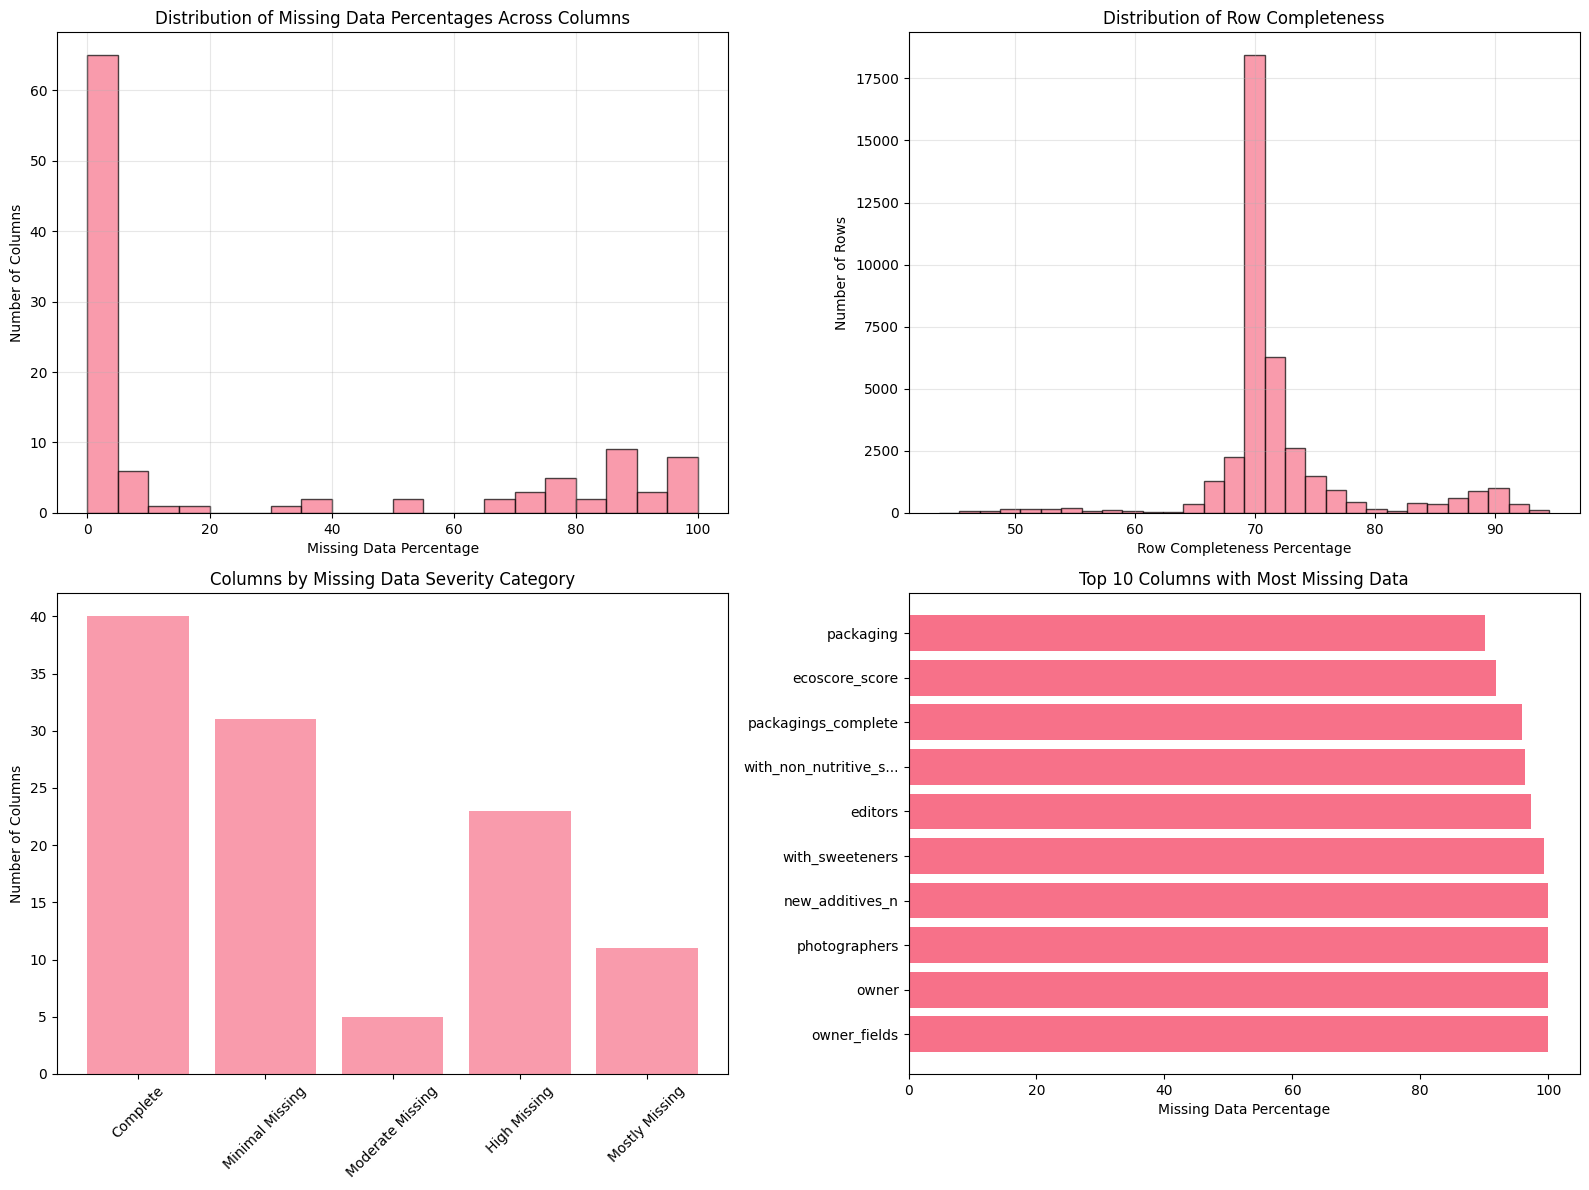

In [9]:
# Visualize missing data patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Missing data percentage distribution
missing_percentages = missing_analysis['missing_summary']['missing_percentage']
axes[0, 0].hist(missing_percentages, bins=20, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Missing Data Percentages Across Columns')
axes[0, 0].set_xlabel('Missing Data Percentage')
axes[0, 0].set_ylabel('Number of Columns')
axes[0, 0].grid(True, alpha=0.3)

# 2. Row completeness distribution
axes[0, 1].hist(missing_analysis['row_completeness'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Row Completeness')
axes[0, 1].set_xlabel('Row Completeness Percentage')
axes[0, 1].set_ylabel('Number of Rows')
axes[0, 1].grid(True, alpha=0.3)

# 3. Missing data by category
category_counts = [len(data) for data in missing_analysis['categories'].values()]
category_names = [name.replace('_', ' ').title() for name in missing_analysis['categories'].keys()]
axes[1, 0].bar(category_names, category_counts, alpha=0.7)
axes[1, 0].set_title('Columns by Missing Data Severity Category')
axes[1, 0].set_ylabel('Number of Columns')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Top missing columns
top_missing_cols = missing_analysis['missing_summary'].head(10)
axes[1, 1].barh(range(len(top_missing_cols)), top_missing_cols['missing_percentage'])
axes[1, 1].set_yticks(range(len(top_missing_cols)))
axes[1, 1].set_yticklabels([col[:20] + '...' if len(col) > 20 else col for col in top_missing_cols['column']])
axes[1, 1].set_title('Top 10 Columns with Most Missing Data')
axes[1, 1].set_xlabel('Missing Data Percentage')

plt.tight_layout()
plt.show()

## 5. Data Quality Flags & Reliability Indicators

In [10]:
def create_data_quality_flags(df: pd.DataFrame) -> pd.DataFrame:
    """Create comprehensive data quality flags for each row"""
    quality_flags = pd.DataFrame(index=df.index)
    
    # Completeness flags
    total_cols = len(df.columns)
    non_null_count = df.notna().sum(axis=1)
    quality_flags['completeness_score'] = (non_null_count / total_cols) * 100
    quality_flags['is_highly_complete'] = quality_flags['completeness_score'] >= 80
    quality_flags['is_moderately_complete'] = (quality_flags['completeness_score'] >= 50) & (quality_flags['completeness_score'] < 80)
    quality_flags['is_sparse'] = quality_flags['completeness_score'] < 50
    
    # Essential fields completeness (key fields for food recommendation)
    essential_fields = ['product_name', 'categories', 'nutriments', 'ingredients_text']
    available_essential = [col for col in essential_fields if col in df.columns]
    
    if available_essential:
        essential_completeness = df[available_essential].notna().sum(axis=1)
        quality_flags['essential_completeness_score'] = (essential_completeness / len(available_essential)) * 100
        quality_flags['has_essential_data'] = quality_flags['essential_completeness_score'] >= 75
    
    # Nutritional data quality
    if 'nutriments' in df.columns:
        quality_flags['has_nutritional_data'] = df['nutriments'].notna()
    
    # Quality scores (if available)
    if 'nutriscore_grade' in df.columns:
        quality_flags['has_nutriscore'] = df['nutriscore_grade'].notna()
    
    if 'nova_group' in df.columns:
        quality_flags['has_nova_score'] = df['nova_group'].notna()
    
    # Data freshness (if timestamp columns available)
    timestamp_cols = [col for col in df.columns if any(term in col.lower() for term in ['created', 'modified', 'updated'])]
    if timestamp_cols:
        quality_flags['has_timestamp_data'] = df[timestamp_cols].notna().any(axis=1)
    
    # Create overall quality score
    quality_components = []
    
    # Completeness component (40%)
    quality_components.append(quality_flags['completeness_score'] * 0.4)
    
    # Essential data component (30%)
    if 'essential_completeness_score' in quality_flags.columns:
        quality_components.append(quality_flags['essential_completeness_score'] * 0.3)
    
    # Quality scores component (20%)
    quality_score_component = 0
    if 'has_nutriscore' in quality_flags.columns:
        quality_score_component += quality_flags['has_nutriscore'].astype(int) * 50
    if 'has_nova_score' in quality_flags.columns:
        quality_score_component += quality_flags['has_nova_score'].astype(int) * 50
    quality_components.append(quality_score_component * 0.2)
    
    # Nutritional data component (10%)
    if 'has_nutritional_data' in quality_flags.columns:
        quality_components.append(quality_flags['has_nutritional_data'].astype(int) * 100 * 0.1)
    
    # Calculate overall quality score
    quality_flags['overall_quality_score'] = sum(quality_components)
    
    # Quality categories
    quality_flags['quality_category'] = pd.cut(
        quality_flags['overall_quality_score'],
        bins=[0, 40, 60, 80, 100],
        labels=['Poor', 'Fair', 'Good', 'Excellent'],
        include_lowest=True
    )
    
    return quality_flags

print("Creating data quality flags and reliability indicators...")
quality_flags = create_data_quality_flags(df)

print(f"\nData Quality Analysis:")
print(f"- Average completeness score: {quality_flags['completeness_score'].mean():.2f}%")
print(f"- Average overall quality score: {quality_flags['overall_quality_score'].mean():.2f}")

print(f"\nQuality Categories Distribution:")
quality_dist = quality_flags['quality_category'].value_counts()
for category, count in quality_dist.items():
    percentage = (count / len(quality_flags)) * 100
    print(f"- {category}: {count:,} products ({percentage:.1f}%)")

if 'essential_completeness_score' in quality_flags.columns:
    print(f"\nEssential Data Completeness:")
    print(f"- Average essential completeness: {quality_flags['essential_completeness_score'].mean():.2f}%")
    print(f"- Products with essential data (≥75%): {quality_flags['has_essential_data'].sum():,} ({(quality_flags['has_essential_data'].sum()/len(quality_flags))*100:.1f}%)")

Creating data quality flags and reliability indicators...

Data Quality Analysis:
- Average completeness score: 71.66%
- Average overall quality score: 87.19

Quality Categories Distribution:
- Excellent: 35,447 products (90.4%)
- Good: 3,371 products (8.6%)
- Fair: 373 products (1.0%)
- Poor: 0 products (0.0%)

Essential Data Completeness:
- Average essential completeness: 98.18%
- Products with essential data (≥75%): 38,930 (99.3%)


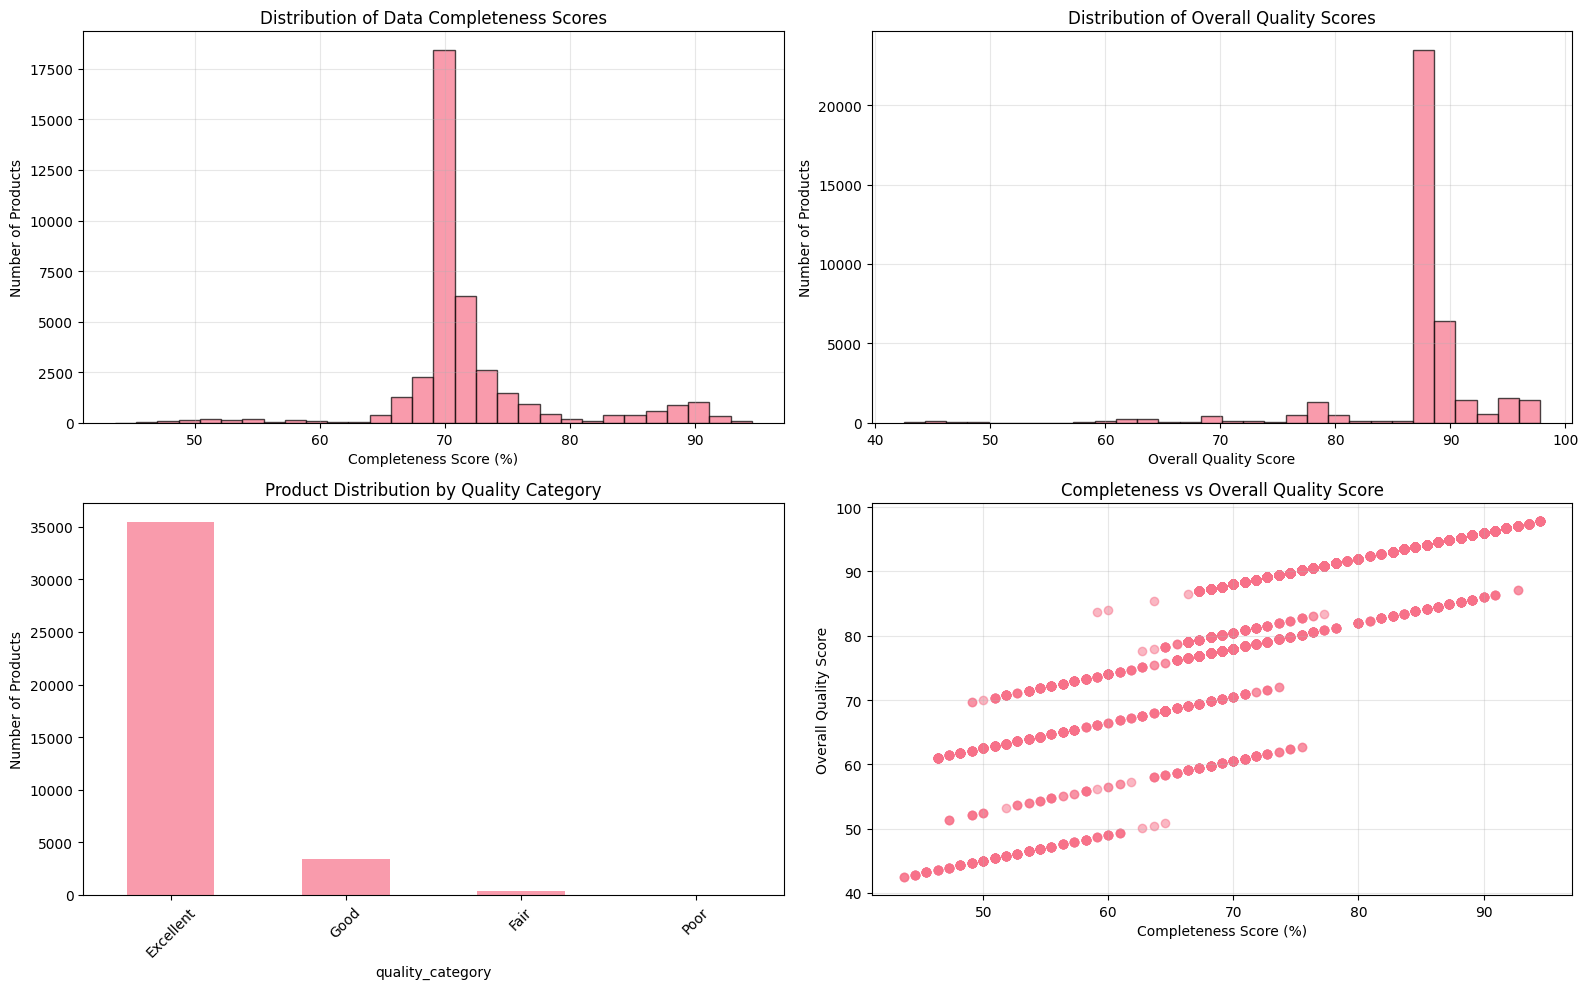

In [11]:
# Visualize data quality distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Completeness score distribution
axes[0, 0].hist(quality_flags['completeness_score'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Data Completeness Scores')
axes[0, 0].set_xlabel('Completeness Score (%)')
axes[0, 0].set_ylabel('Number of Products')
axes[0, 0].grid(True, alpha=0.3)

# 2. Overall quality score distribution
axes[0, 1].hist(quality_flags['overall_quality_score'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Overall Quality Scores')
axes[0, 1].set_xlabel('Overall Quality Score')
axes[0, 1].set_ylabel('Number of Products')
axes[0, 1].grid(True, alpha=0.3)

# 3. Quality categories
quality_dist.plot(kind='bar', ax=axes[1, 0], alpha=0.7)
axes[1, 0].set_title('Product Distribution by Quality Category')
axes[1, 0].set_ylabel('Number of Products')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Correlation between completeness and quality
axes[1, 1].scatter(quality_flags['completeness_score'], quality_flags['overall_quality_score'], alpha=0.5)
axes[1, 1].set_title('Completeness vs Overall Quality Score')
axes[1, 1].set_xlabel('Completeness Score (%)')
axes[1, 1].set_ylabel('Overall Quality Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sample vs Full Dataset Comparison Strategies

In [12]:
def compare_sample_strategies(base_sample_size: str = "1%") -> Dict[str, Any]:
    """Compare different sampling strategies"""
    sample_strategies = {
        '1%': 'train[:1%]',
        '2%': 'train[:2%]',
        '5%': 'train[:5%]'
    }
    
    comparison_results = []
    
    for strategy_name, strategy_split in sample_strategies.items():
        print(f"Testing {strategy_name} sample...")
        
        try:
            # Load sample
            memory_before = get_memory_usage()
            sample_dataset = load_dataset("parquet", data_files="food.parquet", split=strategy_split)
            sample_df = sample_dataset.to_pandas()
            memory_after = get_memory_usage()
            
            # Calculate statistics
            memory_used = memory_after['rss_mb'] - memory_before['rss_mb']
            
            # Basic stats
            result = {
                'strategy': strategy_name,
                'num_rows': len(sample_df),
                'num_cols': len(sample_df.columns),
                'memory_mb': sample_df.memory_usage(deep=True).sum() / 1024**2,
                'loading_memory_mb': memory_used,
                'completeness_avg': sample_df.notna().sum().sum() / (len(sample_df) * len(sample_df.columns)) * 100
            }
            
            # Column-specific completeness
            key_columns = ['product_name', 'categories', 'nutriments', 'nutriscore_grade', 'nova_group']
            available_key_cols = [col for col in key_columns if col in sample_df.columns]
            
            for col in available_key_cols:
                result[f'{col}_completeness'] = (sample_df[col].notna().sum() / len(sample_df)) * 100
            
            comparison_results.append(result)
            
            # Clean up memory
            del sample_dataset, sample_df
            gc.collect()
            
        except Exception as e:
            print(f"Error with {strategy_name} sample: {e}")
            continue
    
    return pd.DataFrame(comparison_results)

print("Comparing different sampling strategies...")
sample_comparison = compare_sample_strategies()

if not sample_comparison.empty:
    print(f"\nSample Strategy Comparison:")
    print(sample_comparison.round(2))
    
    # Recommend optimal sample size
    print(f"\nSample Strategy Recommendations:")
    print(f"- For quick exploration: 1% sample")
    print(f"- For detailed analysis: 2% sample")
    print(f"- For model development: 5% or higher sample")
    
    # Memory efficiency analysis
    if len(sample_comparison) > 1:
        memory_per_row = sample_comparison['memory_mb'] / sample_comparison['num_rows']
        print(f"\nMemory Efficiency:")
        print(f"- Average memory per row: {memory_per_row.mean():.4f} MB")
        print(f"- Estimated full dataset memory: {memory_per_row.mean() * 3500000:.1f} MB (assuming 3.5M total products)")

Comparing different sampling strategies...
Testing 1% sample...
Testing 2% sample...
Testing 5% sample...

Sample Strategy Comparison:
  strategy  num_rows  num_cols  memory_mb  loading_memory_mb  \
0       1%     39191       110     513.47            1421.83   
1       2%     78382       110    1042.40            2881.39   
2       5%    195956       110    2708.82            7048.98   

   completeness_avg  product_name_completeness  categories_completeness  \
0             71.66                      100.0                    93.91   
1             71.61                      100.0                    92.66   
2             70.87                      100.0                    88.13   

   nutriments_completeness  nutriscore_grade_completeness  \
0                    98.81                          100.0   
1                    98.80                          100.0   
2                    97.80                          100.0   

   nova_group_completeness  
0                    91.92  
1   

## 7. Summary & Recommendations

In [13]:
def generate_foundation_analysis_summary(df, column_analysis_df, missing_analysis, quality_flags, optimization_analysis):
    """Generate comprehensive summary of foundation analysis"""
    
    summary = {
        'dataset_overview': {
            'total_products': len(df),
            'total_features': len(df.columns),
            'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2,
            'overall_completeness_pct': missing_analysis['overall_completeness']
        },
        'data_quality': {
            'avg_quality_score': quality_flags['overall_quality_score'].mean(),
            'excellent_quality_products': (quality_flags['quality_category'] == 'Excellent').sum(),
            'poor_quality_products': (quality_flags['quality_category'] == 'Poor').sum()
        },
        'missing_data': {
            'complete_columns': len(missing_analysis['categories']['complete']),
            'mostly_missing_columns': len(missing_analysis['categories']['mostly_missing']),
            'usable_columns': len(missing_analysis['categories']['complete']) + len(missing_analysis['categories']['minimal_missing']) + len(missing_analysis['categories']['moderate_missing'])
        },
        'optimization': {
            'optimizable_columns': len([s for s in optimization_analysis['suggestions'] if s['suggested_dtype'] != s['current_dtype']]),
            'current_memory_mb': optimization_analysis['current_total_memory_mb']
        }
    }
    
    return summary

# Generate summary
analysis_summary = generate_foundation_analysis_summary(
    df, column_analysis_df, missing_analysis, quality_flags, optimization_analysis
)

print("="*60)
print("DATASET FOUNDATION ANALYSIS SUMMARY")
print("="*60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total products: {analysis_summary['dataset_overview']['total_products']:,}")
print(f"   • Total features: {analysis_summary['dataset_overview']['total_features']}")
print(f"   • Memory usage: {analysis_summary['dataset_overview']['memory_usage_mb']:.1f} MB")
print(f"   • Overall completeness: {analysis_summary['dataset_overview']['overall_completeness_pct']:.1f}%")

print(f"\n🎯 DATA QUALITY:")
print(f"   • Average quality score: {analysis_summary['data_quality']['avg_quality_score']:.1f}/100")
print(f"   • Excellent quality products: {analysis_summary['data_quality']['excellent_quality_products']:,}")
print(f"   • Poor quality products: {analysis_summary['data_quality']['poor_quality_products']:,}")

print(f"\n❌ MISSING DATA:")
print(f"   • Complete columns (0% missing): {analysis_summary['missing_data']['complete_columns']}")
print(f"   • Mostly missing columns (>90% missing): {analysis_summary['missing_data']['mostly_missing_columns']}")
print(f"   • Usable columns (≤50% missing): {analysis_summary['missing_data']['usable_columns']}")

print(f"\n⚡ OPTIMIZATION POTENTIAL:")
print(f"   • Columns with optimization potential: {analysis_summary['optimization']['optimizable_columns']}")
print(f"   • Current memory usage: {analysis_summary['optimization']['current_memory_mb']:.1f} MB")

print(f"\n💡 KEY RECOMMENDATIONS:")
print(f"   • Focus on {analysis_summary['missing_data']['usable_columns']} usable columns for analysis")
print(f"   • Consider dropping {analysis_summary['missing_data']['mostly_missing_columns']} mostly-missing columns")
print(f"   • Implement data type optimization for {analysis_summary['optimization']['optimizable_columns']} columns")
print(f"   • Filter products by quality score for reliable analysis")
print(f"   • Use 1-2% samples for development, 5%+ for model training")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Implement data type optimizations")
print(f"   2. Create filtered datasets based on quality scores")
print(f"   3. Proceed with nutritional data mining (Analysis #2)")
print(f"   4. Develop data preprocessing pipeline")

print("\n" + "="*60)

DATASET FOUNDATION ANALYSIS SUMMARY

📊 DATASET OVERVIEW:
   • Total products: 39,191
   • Total features: 110
   • Memory usage: 513.5 MB
   • Overall completeness: 71.7%

🎯 DATA QUALITY:
   • Average quality score: 87.2/100
   • Excellent quality products: 35,447
   • Poor quality products: 0

❌ MISSING DATA:
   • Complete columns (0% missing): 40
   • Mostly missing columns (>90% missing): 11
   • Usable columns (≤50% missing): 76

⚡ OPTIMIZATION POTENTIAL:
   • Columns with optimization potential: 51
   • Current memory usage: 513.5 MB

💡 KEY RECOMMENDATIONS:
   • Focus on 76 usable columns for analysis
   • Consider dropping 11 mostly-missing columns
   • Implement data type optimization for 51 columns
   • Filter products by quality score for reliable analysis
   • Use 1-2% samples for development, 5%+ for model training

🚀 NEXT STEPS:
   1. Implement data type optimizations
   2. Create filtered datasets based on quality scores
   3. Proceed with nutritional data mining (Analysis